# Tumor classification on T2, T1ce and FLAIR mri images

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from helpers import plots

import keras
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
try:
    from tensorflow.python.util import module_wrapper as deprecation
except ImportError:
    from tensorflow.python.util import deprecation_wrapper as deprecation
deprecation._PER_MODULE_WARNING_LIMIT = 0

Using TensorFlow backend.


In [11]:
batch_size = 128
epochs = 8
IMG_HEIGHT = 240
IMG_WIDTH = 240

model_path = '../models/brats_3ch_model_2.h5'

train_dir = '../data/train/t2_t1ce_flair'
valid_dir = '../data/valid/t2_t1ce_flair'

### Define model

In [3]:
model = Sequential([
        Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3), name='conv_a'),
        MaxPooling2D(name='max_a'),
        Dropout(0.2,name='drop_a'),
        Conv2D(32, 3, padding='same', activation='relu', name='conv_b'),
        MaxPooling2D(name='max_b'),
        Conv2D(64, 3, padding='same', activation='relu', name='conv_c'),
        MaxPooling2D(name='max_c'),
        Dropout(0.2, name='drop_b'),
        Flatten(name='flat_a'),
        Dense(512, activation='relu', name='dense_a'),
        Dense(2, activation='softmax', name='dense_b')
    ])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### Dataset initialization

In [4]:
train_image_generator = ImageDataGenerator(rescale=1./255, 
                                           rotation_range=45,
                                           horizontal_flip=True,
                                           vertical_flip=True)
validation_image_generator = ImageDataGenerator(rescale=1./255)

In [5]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           color_mode="rgb",
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical')

val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=valid_dir,
                                                           shuffle=True,
                                                           color_mode="rgb",
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical')

Found 13440 images belonging to 2 classes.
Found 3360 images belonging to 2 classes.


#### Lets visualize dataset samples 

In [6]:
sample_training_images, l = next(val_data_gen)
sample_training_images.shape

(128, 240, 240, 3)

##### rgb images  (r-> T2,  g-> T1ce, b-> Flair)

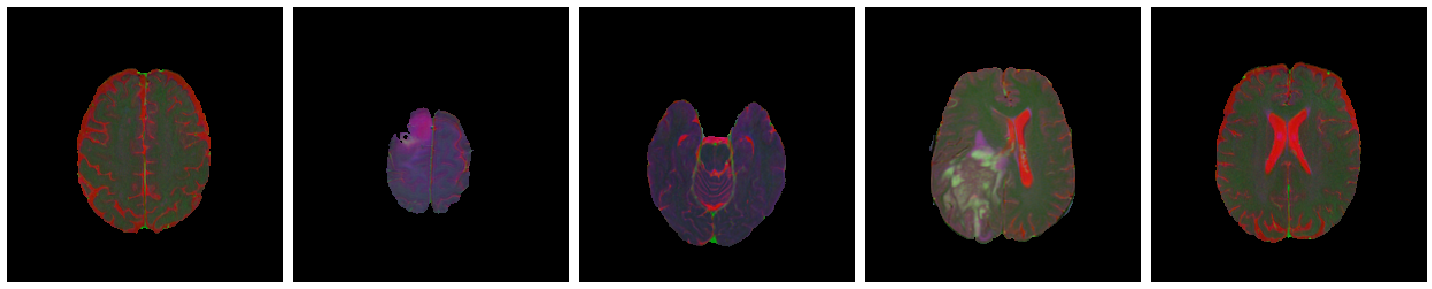

In [7]:
plots.plot_rgb_images(sample_training_images[:5])

#### decomposition of rgb images to individual channels

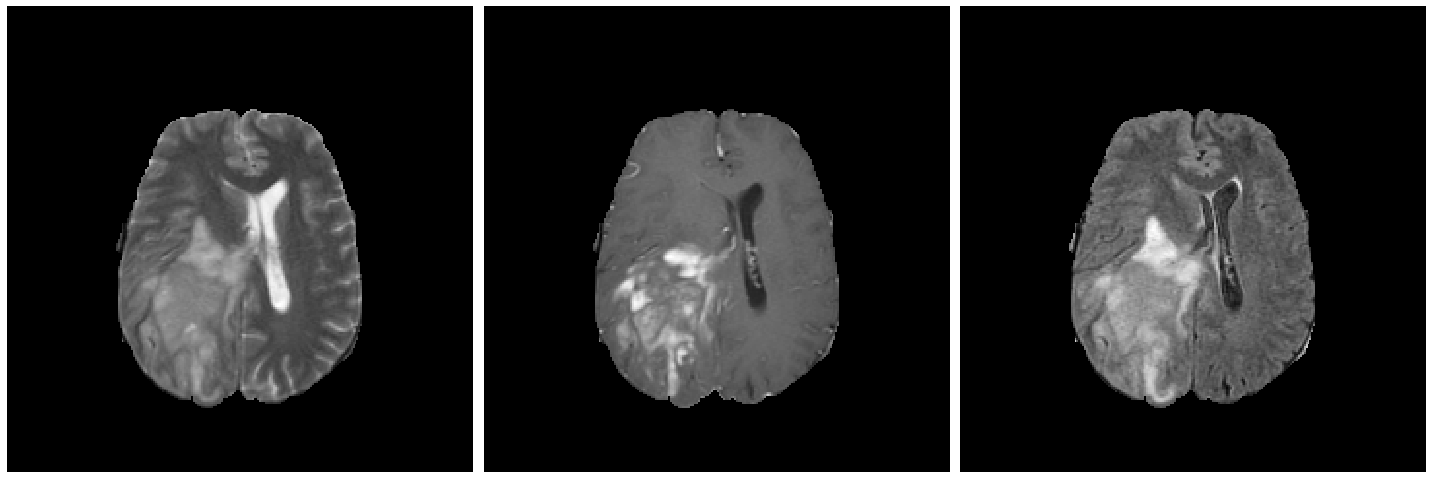

In [8]:
plots.plot_rgb_decomposition(sample_training_images[3])

### Setup and train model

In [9]:
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_a (Conv2D)              (None, 240, 240, 16)      448       
_________________________________________________________________
max_a (MaxPooling2D)         (None, 120, 120, 16)      0         
_________________________________________________________________
drop_a (Dropout)             (None, 120, 120, 16)      0         
_________________________________________________________________
conv_b (Conv2D)              (None, 120, 120, 32)      4640      
_________________________________________________________________
max_b (MaxPooling2D)         (None, 60, 60, 32)        0         
_________________________________________________________________
conv_c (Conv2D)              (None, 60, 60, 64)        18496     
_________________________________________________________________
max_c (MaxPooling2D)         (None, 30, 30, 64)        0         
__________

In [12]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=train_data_gen.samples // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=val_data_gen.samples // batch_size
)

# Save the model
model.save(model_path);

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/8
105/105 [==============================] - 136s 1s/step - loss: 0.5631 - acc: 0.7283 - val_loss: 0.5836 - val_acc: 0.6974
Epoch 2/8
105/105 [==============================] - 131s 1s/step - loss: 0.5064 - acc: 0.7494 - val_loss: 0.5388 - val_acc: 0.7055
Epoch 3/8
105/105 [==============================] - 127s 1s/step - loss: 0.4644 - acc: 0.7653 - val_loss: 0.5514 - val_acc: 0.6640
Epoch 4/8
105/105 [==============================] - 124s 1s/step - loss: 0.4187 - acc: 0.7961 - val_loss: 0.4639 - val_acc: 0.7562
Epoch 5/8
105/105 [==============================] - 126s 1s/step - loss: 0.3284 - acc: 0.8474 - val_loss: 0.3735 - val_acc: 0.8178
Epoch 6/8
105/105 [==============================] - 130s 1s/step - loss: 0.2961 - acc: 0.8670 - val_loss: 0.3373 - val_acc: 0.8280
Epoch 7/8
105/105 [==============================] - 130s 1s/step - loss: 0.2615 - acc: 0.8838 - val_loss: 0.3246 

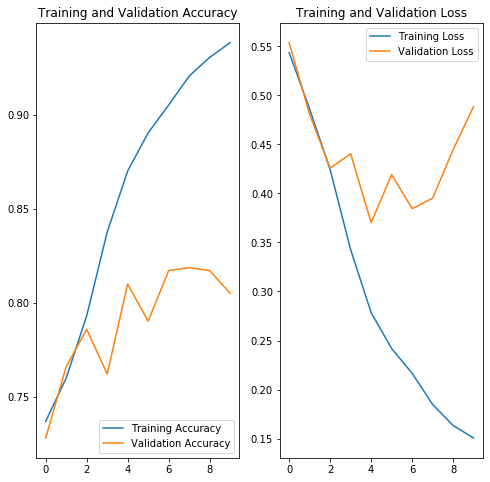

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()